In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [8]:
# LOAD DATA

def unpickle(fname):
    import pickle
    
    with open(fname, 'rb') as fopen:
        res = pickle.load(fopen, encoding = 'bytes')
    
    return res

data_path = '../data'

test = unpickle(data_path + '/test_batch')
test_labels = test[b'labels']
test = test[b'data']

test_len = len(test)

test = test.reshape(test_len, 3, 32, 32)
test = np.rollaxis(test, 1, 4)
test_labels = np.array(test_labels)

train_labels = []
train = None

# load files data_batch 1-5
for i in range(1,6):
    data = unpickle(data_path + '/data_batch_{}'.format(i))
    if i == 1:
        train = data[b'data']
    elif i > 1:
        train = np.vstack((train, data[b'data']))
    train_labels += data[b'labels']

train_len = len(train)

train = train.reshape(train_len, 3, 32, 32)
train = np.rollaxis(train, 1, 4)
train_labels = np.array(train_labels)

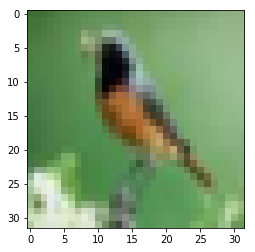

In [15]:
# 2B
# Birds are in Label 2

birds_tr = train[train_labels == 2,:,:,:]
birds_te = test[test_labels == 2,:,:,:]

plt.imshow(birds_te[5])
plt.show()

In [10]:
# 2C

# Generate random indexes for pixels

randn_row = np.random.randint(32,size=(614400,))
randn_col = np.random.randint(32,size=(614400,))
randn_img = np.random.randint(6000,size=(614400,))

# Choose 10% randomly from all birds data

birds = np.concatenate([birds_tr, birds_te])
kmeans_birds =  birds[randn_img, randn_row, randn_col, :]

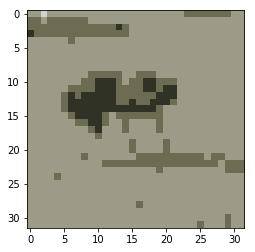

In [48]:
# 2D

# Run kmeans
km = KMeans(n_clusters = 4).fit(kmeans_birds)

# Categorize as 4 colors
birds = (birds.reshape(-1, birds.shape[-1]))
k_color_birds = (birds.reshape(-1, birds.shape[-1]))
k_color_birds = km.predict(k_color_birds)
k_color_birds = km.cluster_centers_[k_color_birds]
k_color_birds = np.uint8(k_color_birds.reshape((6000,32,32,3)))

# Get kmeans predictions
predict = km.predict(birds)
predict = np.eye(predict.max()+1)[predict]
predict = predict.reshape((6000,4096))

# Plot example
plt.imshow(k_color_birds[5])
plt.show()

In [61]:
# 2E

# Convert to grayscale

from skimage.color import rgb2gray
#gray_birds = rgb2gray(birds)
gray_birds = np.dot(birds[..., :3],[0.30,0.59,0.11])
gray_birds = gray_birds.reshape((6000, 32, 32, 1))

In [55]:
# 2F

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from sklearn.model_selection import train_test_split

classifier = Sequential()

# 1. Convolution
classifier.add(Conv2D(64, input_shape = (32, 32, 1), kernel_size = 5, activation = 'relu'))

# 2. Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(32, kernel_size = 5, activation = 'relu'))

# Adding a third convolutional layer
classifier.add(Conv2D(16, kernel_size = 5, activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# 3. Flattening
classifier.add(Flatten())

# 4. Connection
classifier.add(Dense(units = 512, activation='relu'))
classifier.add(Dense(units = 4096, activation='softmax'))

# Compile the CNN

classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [63]:
# split into training and test data

X_train = gray_birds[:5000,:,:,:]
y_train = predict[:5000,:]

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.25, random_state = 1)

results = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 30, batch_size = 32)

Train on 3750 samples, validate on 1250 samples
Epoch 1/30
3750/3750 [==============================] - 14s 4ms/sample - loss: 2.0772 - accuracy: 0.7500 - val_loss: 2.0677 - val_accuracy: 0.7500
Epoch 2/30
3750/3750 [==============================] - 13s 3ms/sample - loss: 2.0682 - accuracy: 0.7500 - val_loss: 2.0657 - val_accuracy: 0.7500
Epoch 3/30
3750/3750 [==============================] - 13s 3ms/sample - loss: 2.0679 - accuracy: 0.7500 - val_loss: 2.0657 - val_accuracy: 0.7500
Epoch 4/30
3750/3750 [==============================] - 12s 3ms/sample - loss: 2.0679 - accuracy: 0.7500 - val_loss: 2.0657 - val_accuracy: 0.7500
Epoch 5/30
3750/3750 [==============================] - 13s 3ms/sample - loss: 2.0679 - accuracy: 0.7500 - val_loss: 2.0659 - val_accuracy: 0.7500
Epoch 6/30
3750/3750 [==============================] - 13s 3ms/sample - loss: 2.0679 - accuracy: 0.7500 - val_loss: 2.0658 - val_accuracy: 0.7500
Epoch 7/30
3750/3750 [==============================] - 13s 3ms/sample

(6144000, 3)